# Metabolites Simulation : Initial Phase

This code implements an initial phase of a metabolites simulation. Here, some topics were explored:
1. Chemical shift dynamics.
2. Axis inversion for plotting.
3. Metabolites chemical shifts and T2 registering.

For some information about MRS, metabolites, chemical shifts and more, please visit: [https://mri-q.com/hellipmr-spectroscopy.html](https://mri-q.com/hellipmr-spectroscopy.html)


In [23]:
import numpy as np
from pyMRI import pymri
import matplotlib.pyplot as plt

First, some useful functions are declared. The chemical shift and frequency functions were all declared expecting a frequency in the order of MHz.

In [24]:
hz_to_rad = lambda f : 2*np.pi*f # Converts hz to radians/s
rad_to_hz = lambda w : w/(2*np.pi) # Converts radians/s to hz

def f_from_chem_shift(delta : float, B0 : float):
    """Returns the frequency in MHz (Megacycles/s) of a given compound 
    based on its chemical shift and magnetic field B0. It uses tetramethylsilane as reference.
    
    Parameters
    ----------
    
    delta : float                      [ppm]
        Chemical shift value, in ppm.
    B0 : float                         [T]
        Magnetic field B0, in T."""
    gamma = 42.577478461
    f_ref = gamma*B0
    return f_ref*(delta + 1.0)

def chem_shift_from_f(f : float, B0 : float):
    """Returns the chemical shift in ppm (parts per million) of a given compound 
    based on its frequency and magnetic field B0. It uses tetramethylsilane as reference.
    
    Parameters
    ----------
    
    f : float                       [MHz]
        Frequency value, in MHz.
    B0 : float                      [T]
        Magnetic field B0, in T."""
    gamma = 42.577478461
    f_ref =  gamma*B0
    return (f - f_ref)/f_ref

The parameters are then set:

In [25]:
sampling_f = 100000 # cycles/s -> 2000 cycles/s -> 2048 points
t0 = 0.0
tn = 1.0
Dt = tn - t0
dt = 1.0/(sampling_f)
B0 = 3.0

In [26]:
# metabolites = {"glutamato"              : (3.7444,  89*1e-3), # (δ, T2) [ppm, s]
#                "glutamina"              : (3.7625, 116*1e-3),
#                "gaba"                   : (3.0082, 105*1e-3),
#                "myo-inositol"           : (3.5177, 148*1e-3),
#                "phosphorylethanolamine" : (3.9825,  96*1e-3),
#                "phosphocreatine"        : (3.0280, 113*1e-3),
#                "taurina"                : (3.4190,  93*1e-3),
#                "naa"                    : (2.0050, 202*1e-3)}


metabolites = pymri.METABOLITES

In [27]:
deltas = np.array(list(metabolites.values()))[:, 0]
t2s = np.array(list(metabolites.values()))[:, 1]
spins_phi = np.zeros_like(deltas)
ws = hz_to_rad(f_from_chem_shift(deltas, B0) )

print( rad_to_hz(ws) )
print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")

[374.84360487 383.83596833 397.33728675 397.97594892 418.92406833
 428.50400098 515.52810921 539.03087732 543.75697743 584.00546781
 593.45766803 611.35298223 632.42883407 654.4115862 ]
All frequencies are captured by the sampling rate.


And the simulation can then be ran:

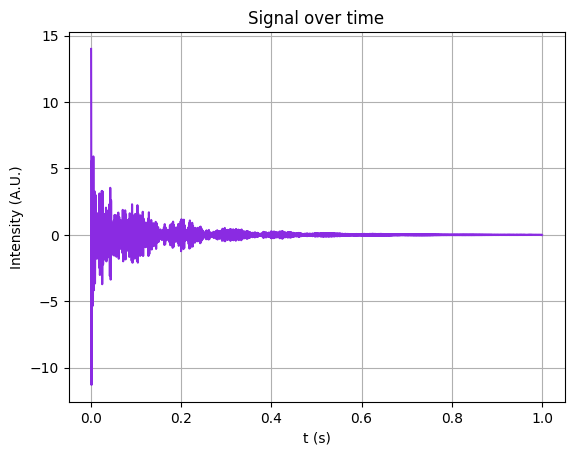

In [28]:
y, t = pymri.population_transverse_decay(t0, tn, dt, (ws, t2s, 1.0, spins_phi), np.array([]))

plt.plot(t, y, c = "blueviolet")
plt.title("Signal over time")
plt.xlabel("t (s)")
plt.ylabel("Intensity (A.U.)")
plt.grid()

With the simulation results, the fourier decomposition can be made:

In [29]:
from numpy.fft import fft, fftfreq, fftshift

print(y.size)
sig_fft = fftshift(fft(y, y.size))
freqs = chem_shift_from_f(fftshift(fftfreq(y.size, d = dt)), B0)
plot_freqs = freqs[freqs.size//2:]
plot_sig_fft = sig_fft[freqs.size//2:]

center = plot_freqs.size//2
b = plot_freqs.size//2
b = int(45*100*dt*b)

100000


Giving the following results:

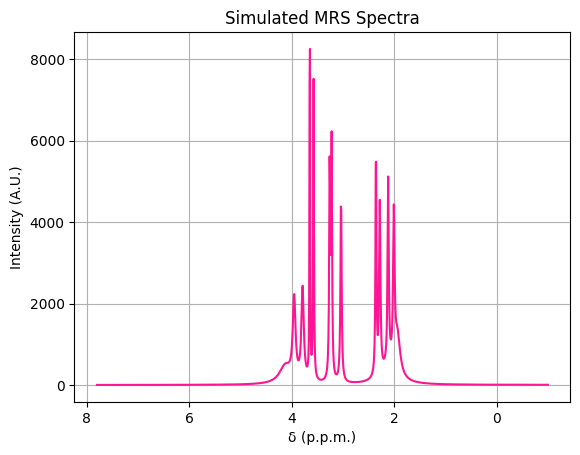

In [30]:
plt.plot(plot_freqs[:b], plot_sig_fft.real[:b], c = "deeppink")
plt.title("Simulated MRS Spectra")
plt.xlabel("δ (p.p.m.)")
plt.ylabel("Intensity (A.U.)")
plt.gca().invert_xaxis() #inverts the x axis
plt.grid()

## Discussion

From the values previously set and the above result, some conclusions can be made:
1. The metabolites previously set can be accurately identified, hence the simulation was succesful.
2. The T2 influences directly on the height of the peak. This makes sense because larger T2s mean that frequency will be present for more time, 
increasing its weight on the fourier domain.

## Signal Corruption

Now that a original clean signal could be obtained, the next step is to implement some kind of signal corruption, that operates with the goal of making the signal's readability customizable. For that, some methods inspired by the article "Comparison of convolutional‑neural‑networks‑based method and LCModel on the quantification of in vivo magnetic resonance spectroscopy"", by Yu‑Long Huang and others, will be applied with the goals:

1. Spectra linewidths (LW) broadening.
2. Decrease of signal to noise ratio (SNR).
3. Macromolecules (MM) addition.

### LW broadening

In [31]:

s = 0.2
M_0 = 1.0

corrup_pop = pymri.corrupted_lw(t2s, s, ws, M_0, spins_phi)

corrup_y, t = pymri.population_transverse_decay(t0, tn, dt, corrup_pop, np.array([]))

final_y = corrup_y

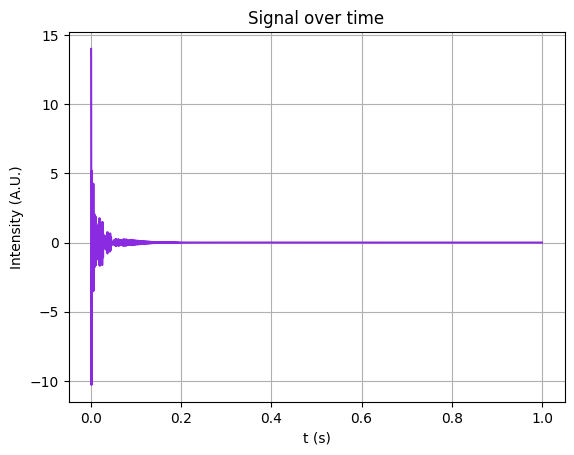

In [32]:
plt.plot(t, final_y, c = "blueviolet")
plt.title("Signal over time")
plt.xlabel("t (s)")
plt.ylabel("Intensity (A.U.)")
plt.grid()

In [33]:
c_sig_fft = fftshift(fft(final_y, final_y.size))
c_freqs = chem_shift_from_f(fftshift(fftfreq(final_y.size, d = dt)), B0)

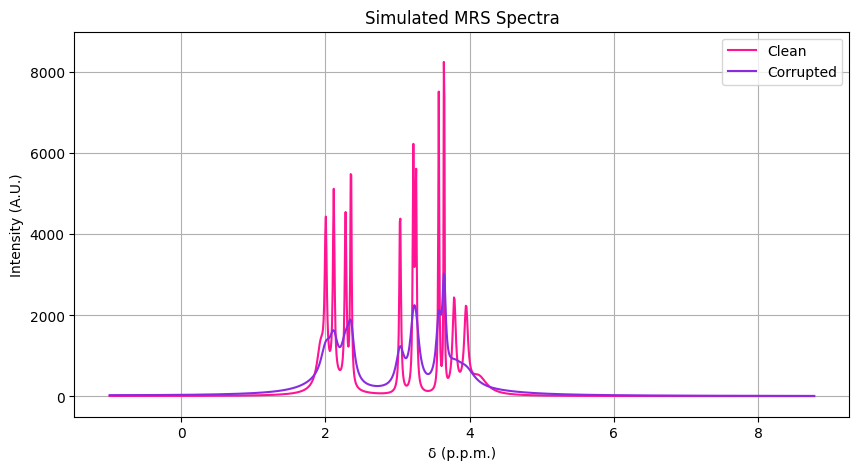

In [34]:
# pymri.plot_chem_shifts(c_freqs, c_sig_fft, 0.05)

plt.figure(figsize=(10, 5))

# plt.subplot(121)
pymri.plot_chem_shifts(freqs, sig_fft, 0.05, label = "Clean")
pymri.plot_chem_shifts(c_freqs, c_sig_fft, 0.05, c = "blueviolet", label = "Corrupted")
# plt.subplot(122)
plt.ylim(-500, 9000)
plt.grid()
plt.legend()

### SNR

In [35]:
sigma = 1.0
center = sigma
a = 0.3

snr = pymri.corrupted_snr(y, center, sigma, a)


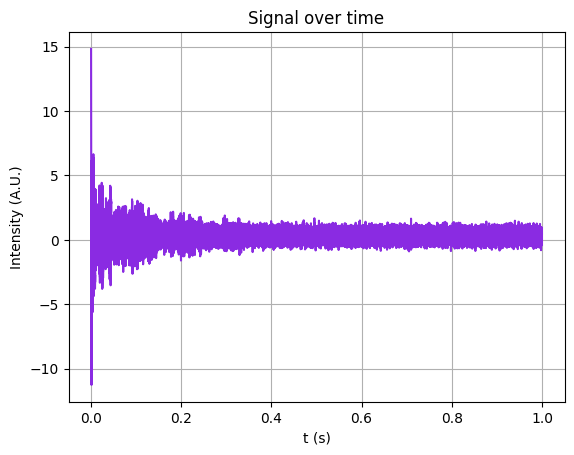

In [36]:
plt.plot(t, snr.real, c = "blueviolet")
plt.title("Signal over time")
plt.xlabel("t (s)")
plt.ylabel("Intensity (A.U.)")
plt.grid()

In [37]:
corrup_sig_fft = fftshift(fft(snr, snr.size))
corrup_freqs = chem_shift_from_f(fftshift(fftfreq(snr.size, d = dt)), B0)

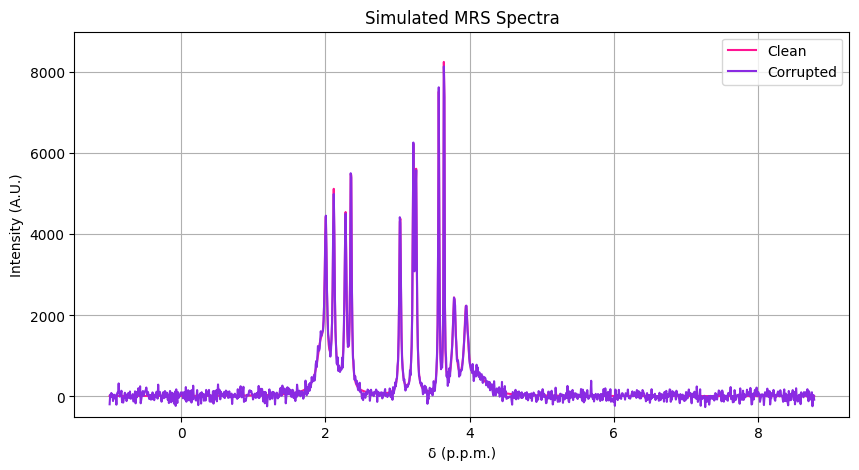

In [38]:
# pymri.plot_chem_shifts(corrup_freqs, corrup_sig_fft, 0.05)

plt.figure(figsize=(10, 5))

# plt.subplot(121)
pymri.plot_chem_shifts(freqs, sig_fft, 0.05, label = "Clean")
pymri.plot_chem_shifts(corrup_freqs, corrup_sig_fft, 0.05, c = "blueviolet", label = "Corrupted")
# plt.subplot(122)
plt.ylim(-500, 9000)
plt.grid()
plt.legend()



In [39]:
print(pymri.snr(corrup_sig_fft))


1.818536185682317


### MM

## LW + SNR + MM



In [40]:
s = 0.2
M_0 = 1.0

corrup_pop = pymri.corrupted_lw(t2s, s, ws, M_0, spins_phi)

corrup_y, t = pymri.population_transverse_decay(t0, tn, dt, corrup_pop, np.array([]))

In [41]:
sigma = 1.0
center = sigma
a = 0.3

snr = pymri.corrupted_snr(corrup_y, center, sigma, a)

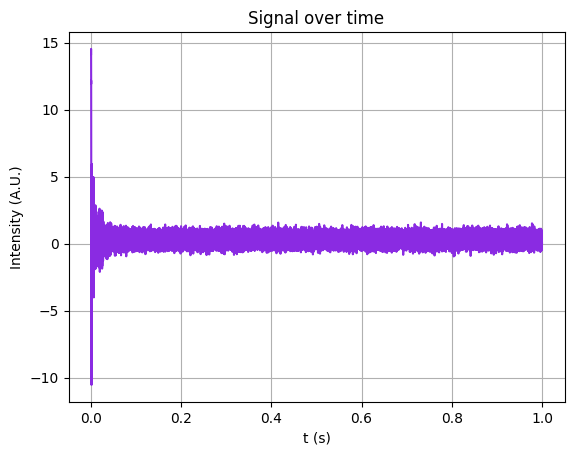

In [42]:
plt.plot(t, snr.real, c = "blueviolet")
plt.title("Signal over time")
plt.xlabel("t (s)")
plt.ylabel("Intensity (A.U.)")
plt.grid()

In [43]:
corrup_sig_fft = fftshift(fft(snr, snr.size))
corrup_freqs = chem_shift_from_f(fftshift(fftfreq(snr.size, d = dt)), B0)

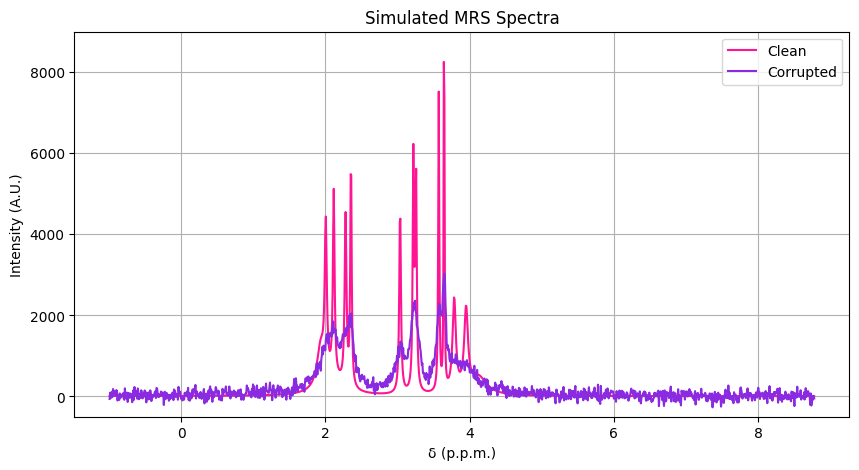

In [44]:
plt.figure(figsize=(10, 5))

# plt.subplot(121)
pymri.plot_chem_shifts(freqs, sig_fft, 0.05, label = "Clean")
pymri.plot_chem_shifts(corrup_freqs, corrup_sig_fft, 0.05, c = "blueviolet", label = "Corrupted")
# plt.subplot(122)
plt.ylim(-500, 9000)
plt.grid()
plt.legend()